# **Market Basket Analysis - Parte 2**

---


Esta é a parte 2 (Criação do modelo preditivo) de um dos projetos de conclusão do módulo Business Analytics da Formação Cientista de Dados da Data Science Academy (DSA)

## **Definição do problema**

Nesse projeto, utilizarei os dados anônimos fornecidos pelo instacart para prever quais produtos adquiridos anteriormente estarão no próximo pedido de um usuário. O instacart é um aplicativo de compras online, onde os compradores selecionam os produtos no app e a entrega é feita na loja mais próxima à você.

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from:

https://www.instacart.com/datasets/grocery-shopping-2017 on 25/05/2020.

Post do VP da Instacart definindo o problema em detalhes:

https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2?gi=41f7b19cd164

In [ ]:
# Pacotes
library(sqldf)
library(Matrix)
library(xgboost)
library(methods)
library(caret)
library(dplyr)
library(cowplot)
library(randomForest) 
library(rpart)
library(ROCR)
library(pROC)
library(repr)

In [3]:
# Carregando datasets
orders = read.csv("orders.csv", sep = ",")
products = read.csv("products.csv", sep = ",")
aisles = read.csv("aisles.csv", sep = ",")
departments = read.csv("departments.csv", sep = ",")
order_products_train = read.csv("order_products__train.csv", sep = ",")

## **Transformação**

In [4]:
# Dataset com os dados
dados = order_products_train

In [5]:
# Transformando a frequencia do product_id no "peso do produto
dados$product_id = factor(dados$product_id)
product_id2 = as.data.frame(table(dados$product_id))
colnames(product_id2) = c("product_id", "product_freq")

# adicionando colunas aisles e departments
product_id2 = merge(product_id2, products, by = "product_id")
head(product_id2)

,product_id,product_freq,product_name,aisle_id,department_id
,<fct>,<int>,<fct>,<int>,<int>
1,1,76,Chocolate Sandwich Cookies,61,19
2,10,119,Sparkling Orange Juice & Prickly Pear Beverage,115,7
3,100,20,Peanut Butter & Strawberry Jam Sandwich,38,1
4,1000,87,Apricots,18,10
5,10000,2,Refresher Strawberry Lemonade,64,7
6,10001,1,Green with Mint Cold Brewed Iced Tea Bags,94,7


In [6]:
# Adicionando as frequências de products, aisles e departments nos dados
aisle_id2 = sqldf( " SELECT aisle_id, SUM(product_freq) AS aisle_freq
                      FROM product_id2 
                      GROUP BY aisle_id " )


department_id2 = sqldf( " SELECT department_id, SUM(product_freq) AS department_freq
                          FROM product_id2 
                          GROUP BY department_id " )

product_id2 = sqldf( " SELECT p.product_id, p.product_freq, a.aisle_freq, d.department_freq
                       FROM product_id2 AS p
                       LEFT JOIN aisle_id2 AS a
                       ON p.aisle_id = a.aisle_id
                       LEFT JOIN department_id2 AS d
                       ON p.department_id = d.department_id " )

# Inserir product_id2 nos dados
dados2 = merge(dados, product_id2, by = "product_id")

# Visualização
head(dados2)

,product_id,order_id,add_to_cart_order,reordered,product_freq,aisle_freq,department_freq
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,1753356,1,1,76,9980,118862
2,1,2742935,2,1,76,9980,118862
3,1,943055,14,0,76,9980,118862
4,1,3357764,6,1,76,9980,118862
5,1,2050666,6,0,76,9980,118862
6,1,1627973,1,0,76,9980,118862


In [7]:
# Dados sobre o perfil de compra do usuário
user_days_since_order = sqldf( " SELECT user_id, AVG(days_since_prior_order) AS user_avg_days
                                 FROM orders 
                                 WHERE days_since_prior_order IS NOT NULL
                                 GROUP BY user_id " )

user_order_number = sqldf( " SELECT user_id, MAX(order_number) as user_last_order
                             FROM orders
                             GROUP BY user_id " )

user_id2 = sqldf( " SELECT o.order_id, o.user_id, o.order_number, d.user_avg_days, n.user_last_order
                    FROM orders AS o
                    LEFT JOIN user_days_since_order AS d
                    ON o.user_id = d.user_id
                    LEFT JOIN user_order_number AS n
                    ON o.user_id = n.user_id " )

# Inserir perfil do usuário nos dados
dados3 = merge(dados2, user_id2, by = "order_id")

# Mudar as colunas de posição - (colunas id no início e coluna reorder por último)
dados4 = dados3[, c(1,2,8,3,5,6,7,9,10,11,4)]

# Visualização
head(dados4)

,order_id,product_id,user_id,add_to_cart_order,product_freq,aisle_freq,department_freq,order_number,user_avg_days,user_last_order,reordered
,<int>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>
1,1,49302,112108,1,8,55240,217051,4,10.33333,4,1
2,1,22035,112108,8,1993,41699,217051,4,10.33333,4,1
3,1,47209,112108,7,7293,150473,409087,4,10.33333,4,0
4,1,11109,112108,2,144,12820,217051,4,10.33333,4,1
5,1,13176,112108,6,15480,150473,409087,4,10.33333,4,0
6,1,43633,112108,5,24,3241,46799,4,10.33333,4,1


In [8]:
# Separação dados de treino e dados de teste 
amostra = floor(nrow(dados4) * 0.8)                  # 80% para treino e 20% para teste
data_train = dados4[1:amostra, ]                     # dataset de treino - primeiros 80%
data_test  = dados4[(amostra+1):nrow(dados4), ]      # dataset de teste - 20% restantes

## **Modelo - XGBoost**

In [64]:
# Dados de entrada (Treino) 
data = as.matrix(data_train[4:10]) 

# Dados considerados:
# add_to_cart_order (4)
# product_freq (5)
# aisle_freq (6)
# department_freq (7)
# order_number (8)
# user_avg_days (9)
# user_last_order (10)

In [10]:
# Set dos parâmetros
param = list("objective" = "binary:logitraw",
            "bst:eta" = 0.1,
            "bst:max_depth" = 6,
             "eval_metric" = "auc",
             "eval_metric" = "ams@0.15",
             "silent" = 1,
             "nthread" = 16)

label = data_train$reordered
xgmat = xgb.DMatrix(data, label = label)

# Visuzalização
str(xgmat)

Class 'xgb.DMatrix' <externalptr> 
 - attr(*, ".Dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:7] "add_to_cart_order" "product_freq" "aisle_freq" "department_freq" ...


In [ ]:
# Criação do modelo
bst = xgboost(params = param, data = xgmat, nround = 120)

In [ ]:
# Dados de entrada (Treino) 
data = as.matrix(data_test[4:10]) 

# Aplicação do modelo
xgmat = xgb.DMatrix(data)
ypred = predict(bst, xgmat, type = "prob")

### **Aplicação do modelo com threshold estimado** 

Threshold calculado à partir da proporção de respostas "yes" observadas nos dados de treino.

In [13]:
# Estimativa do threshold com base nas respostas dos dados de treino
respostas_yes = sum(data_train$reordered)
respostas_no = length(data_train$reordered) - respostas_yes
threshold = respostas_yes/(respostas_yes + respostas_no)
print(threshold) # 60% dos valores serão considerados "yes"

[1] 0.5985548


In [14]:
# Cálculo do Output - Utilizando threshold estimado
rorder = rank(ypred, ties.method = "first" ) # Ranqueia valores ypred                           
ntop = length(rorder) - as.integer(threshold * length(rorder))
plabel = ifelse(rorder > ntop, 1, 0)
outdata_binario = list("prediction" = plabel) 

# Matriz de confusão
pred_xgboost = as.data.frame(outdata_binario)
pred_xgboost$prediction = factor(pred_xgboost$prediction, labels = c("no", "yes"))
data_test$reordered = factor(data_test$reordered, labels = c("no", "yes"))
confusion = confusionMatrix(pred_xgboost$prediction, data_test$reordered)
confusion

Confusion Matrix and Statistics

          Reference
Prediction     no    yes
       no   66863  44307
       yes  44252 121502
                                          
               Accuracy : 0.6802          
                 95% CI : (0.6785, 0.6819)
    No Information Rate : 0.5988          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.3345          
                                          
 Mcnemar's Test P-Value : 0.856           
                                          
            Sensitivity : 0.6017          
            Specificity : 0.7328          
         Pos Pred Value : 0.6014          
         Neg Pred Value : 0.7330          
             Prevalence : 0.4012          
         Detection Rate : 0.2414          
   Detection Prevalence : 0.4014          
      Balanced Accuracy : 0.6673          
                                          
       'Positive' Class : no              
            

In [15]:
# Cálculo da Área Under the Curve (AUC) - valores binários
pred = prediction(outdata_binario, data_test$reordered)
AUC_xgboost_bin = performance(pred, measure = "auc")
AUC_xgboost_bin = AUC_xgboost_bin@y.values[[1]]
AUC_xgboost_bin

[1] 0.6672644

In [16]:
# Cálculo da Área Under the Curve (AUC) - valores contínuos
outdata = prediction(ypred, data_test$reordered)
AUC_xgboost = performance(outdata,"auc")
AUC_xgboost = AUC_xgboost@y.values[[1]]
AUC_xgboost

[1] 0.7356433

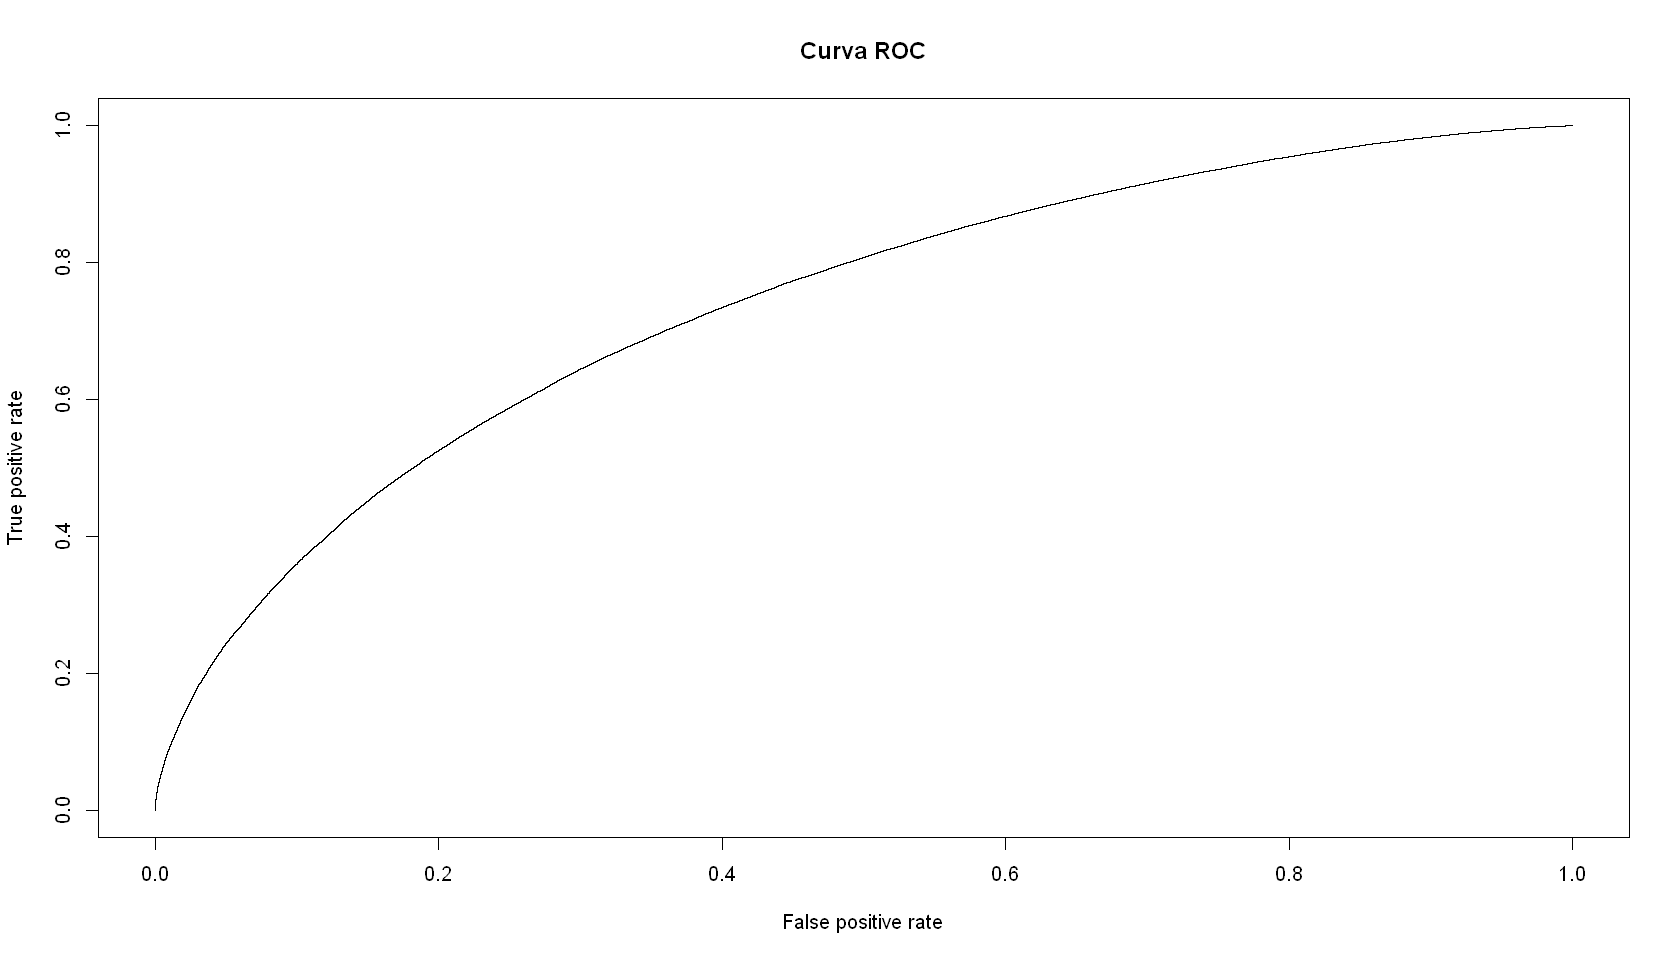

In [45]:
# Plot da curva ROC
options(repr.plot.width=14, repr.plot.height=8)
perform = performance(outdata, measure = "tpr", x.measure = "fpr")
plot(perform, main = "Curva ROC")

### **Aplicação do modelo com threshold ideal**

O threshold será calculado com no índice que fornecer a maior acurácia. Existem várias formas de se calcular a acurácia, e a`confusionMatrix` fornece uma delas. Essa acurácia é calculada pela quantidade de acertos (positivos e negativos) dividido pelo número total da amostra. (TP + TN)/(P + N)

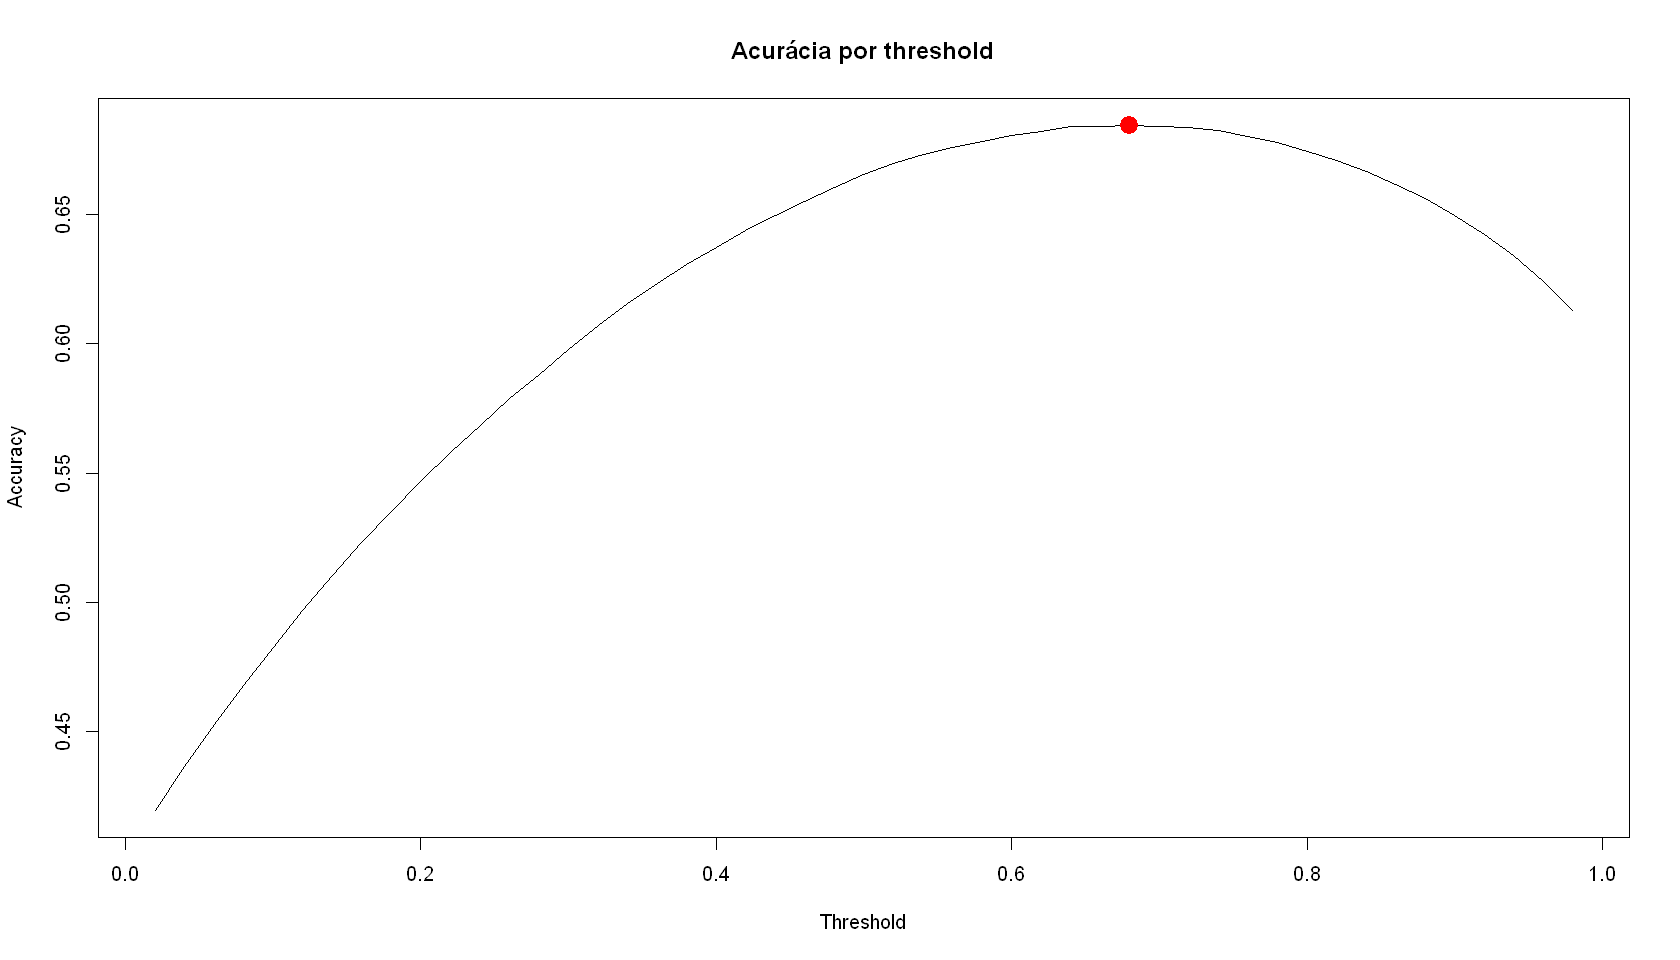

In [46]:
# Threshold ideal com base na acurácia dos resultados - pela fórmula da confusion matrix
thresh = c(0)
acc = c(0)

for (i in 1:49) {
    # Formatação da tabela de saída
    rorder = rank(ypred, ties.method = "first" ) # Ranqueia valores ypred
    threshold = 0.02*i                              # 60% dos valores serão considerados "yes"
    ntop = length(rorder) - as.integer(threshold * length(rorder))
    plabel = ifelse(rorder > ntop, 1, 0)
    outdata_binario = list("prediction" = plabel) 

    # Matriz de confusão
    pred_xgboost = as.data.frame(outdata_binario)
    pred_xgboost$prediction = factor(pred_xgboost$prediction, labels = c("no", "yes"))
    data_test$reordered = factor(data_test$reordered, labels = c("no", "yes"))
    confusion = confusionMatrix(pred_xgboost$prediction, data_test$reordered)
    
    thresh[i] = threshold
    acc[i] = confusion$overall[1]
}

plot(x = thresh, y = acc, type = "l", ylab = "Accuracy", xlab = "Threshold", main = "Acurácia por threshold")
points(x = which.max(acc)*0.02, max(acc), col = "red", pch = 19,  cex = 2 )

In [47]:
#Threshold ideal
threshold = max(acc)
threshold

[1] 0.6841119

In [48]:
# Formatação do output - Utilizando threshold ideal
rorder = rank(ypred, ties.method = "first" ) # Ranqueia valores ypred                           
ntop = length(rorder) - as.integer(threshold * length(rorder))
plabel = ifelse(rorder > ntop, 1, 0)
outdata_binario = list("prediction" = plabel) 

# Matriz de confusão
pred_xgboost = as.data.frame(outdata_binario)
pred_xgboost$prediction = factor(pred_xgboost$prediction, labels = c("no", "yes"))
data_test$reordered = factor(data_test$reordered, labels = c("no", "yes"))
confusion = confusionMatrix(pred_xgboost$prediction, data_test$reordered)
confusion

Confusion Matrix and Statistics

          Reference
Prediction     no    yes
       no   55546  31931
       yes  55569 133878
                                          
               Accuracy : 0.684           
                 95% CI : (0.6823, 0.6858)
    No Information Rate : 0.5988          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.3185          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4999          
            Specificity : 0.8074          
         Pos Pred Value : 0.6350          
         Neg Pred Value : 0.7067          
             Prevalence : 0.4012          
         Detection Rate : 0.2006          
   Detection Prevalence : 0.3159          
      Balanced Accuracy : 0.6537          
                                          
       'Positive' Class : no              
            

In [49]:
# Cálculo da Área Under the Curve (AUC) - valores binários
pred = prediction(outdata_binario, data_test$reordered)
AUC_xgboost_bin = performance(pred, measure = "auc")
AUC_xgboost_bin = AUC_xgboost_bin@y.values[[1]]
AUC_xgboost_bin

[1] 0.6536598

In [50]:
# Cálculo da Área Under the Curve (AUC) - valores contínuos
outdata = prediction(ypred, data_test$reordered)
AUC_xgboost = performance(outdata,"auc")
AUC_xgboost = AUC_xgboost@y.values[[1]]
AUC_xgboost

[1] 0.7356433

**Conclusão** : Mesmo que o threshold ideal tenha aumentado a acurácia de forma geral, ele aumenta a quantidade de falsos positivos, diminuindo assim a AUC. Isso acontece pois a fórmula da acurácia, considera a acurácia total (true-positives e true-negatives) já a AUC considera o desempenho dos true-positives e false-positives.

Como o maior foco desse projeto é descobrir os true-positives, levarei o resultado do threshold estimado para a conclusão, pois ele demonstrou desempenho melhor na identificação de true-positives.

Vale destacar também, que é muito mais prático fazer uma estimativa, nem sempre será viável calcular precisamente qual é o threshold ideal. 

Essa conclusão é válida apenas para esse problema. Há momentos em que a acurácia total é mais importante do que o valor da AUC, cabendo interpretação do analista.

## **Modelo - Regressão Logística**

In [51]:
# Criação do modelo
model = glm(formula = (reordered) ~   
             + add_to_cart_order
             + product_freq
             + aisle_freq
             + department_freq
             + order_number
             + user_avg_days,
             family = binomial(logit), data = data_train)

summary(model)


Call:
glm(formula = (reordered) ~ +add_to_cart_order + product_freq + 
    aisle_freq + department_freq + order_number + user_avg_days, 
    family = binomial(logit), data = data_train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3051  -1.1596   0.6484   1.0248   2.4596  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        3.789e-01  8.834e-03   42.89   <2e-16 ***
add_to_cart_order -4.113e-02  2.818e-04 -145.93   <2e-16 ***
product_freq       1.092e-04  1.062e-06  102.90   <2e-16 ***
aisle_freq        -1.883e-06  7.940e-08  -23.72   <2e-16 ***
department_freq    1.254e-06  2.879e-08   43.55   <2e-16 ***
order_number       3.080e-02  1.972e-04  156.17   <2e-16 ***
user_avg_days     -2.413e-02  3.694e-04  -65.33   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1492269  on 1107692  degrees of freedom
Residual de

In [52]:
# Teste de relevância das variáveis
print(anova(model, test = "Chisq"))

Analysis of Deviance Table

Model: binomial, link: logit

Response: (reordered)

Terms added sequentially (first to last)


                  Df Deviance Resid. Df Resid. Dev  Pr(>Chi)    
NULL                            1107692    1492269              
add_to_cart_order  1    23675   1107691    1468595 < 2.2e-16 ***
product_freq       1    26189   1107690    1442406 < 2.2e-16 ***
aisle_freq         1      616   1107689    1441790 < 2.2e-16 ***
department_freq    1     2019   1107688    1439770 < 2.2e-16 ***
order_number       1    66159   1107687    1373612 < 2.2e-16 ***
user_avg_days      1     4297   1107686    1369315 < 2.2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


**Obs:** Todas as variáveis são importantes para o modelo, sendo order_number a mais relevante e aisle_freq a menos importante.

In [53]:
# Confusion Matrix - No caso da regressão logística, não é necessário um threshold  (considerar 0.5)
ypred = predict(model, data_test, type = "response")
plabel = ifelse(ypred > 0.5, 1, 0)
outdata_binario = list("prediction" = plabel) 
pred_logistic = as.data.frame(outdata_binario)
pred_logistic$prediction = factor(pred_logistic$prediction, labels = c("no", "yes"))
data_test$reordered = factor(data_test$reordered, labels = c("no", "yes"))
confusionMatrix(data = factor(pred_logistic$prediction), reference = data_test$reordered)

Confusion Matrix and Statistics

          Reference
Prediction     no    yes
       no   46226  30409
       yes  64889 135400
                                          
               Accuracy : 0.6559          
                 95% CI : (0.6541, 0.6576)
    No Information Rate : 0.5988          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2452          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.4160          
            Specificity : 0.8166          
         Pos Pred Value : 0.6032          
         Neg Pred Value : 0.6760          
             Prevalence : 0.4012          
         Detection Rate : 0.1669          
   Detection Prevalence : 0.2767          
      Balanced Accuracy : 0.6163          
                                          
       'Positive' Class : no              
            

In [54]:
# Cálculo da Área Under the Curve (AUC) - valores binários
pred = prediction(outdata_binario, data_test$reordered)
AUC_logistic_bin = performance(pred, measure = "auc")
AUC_logistic_bin = AUC_logistic_bin@y.values[[1]]
AUC_logistic_bin

[1] 0.6163108

In [55]:
# Cálculo da Área Under the Curve (AUC) - valores contínuos
outdata = prediction(ypred, data_test$reordered)
AUC_logistic = performance(outdata,"auc")
AUC_logistic = AUC_logistic@y.values[[1]]
AUC_logistic

[1] 0.6934933

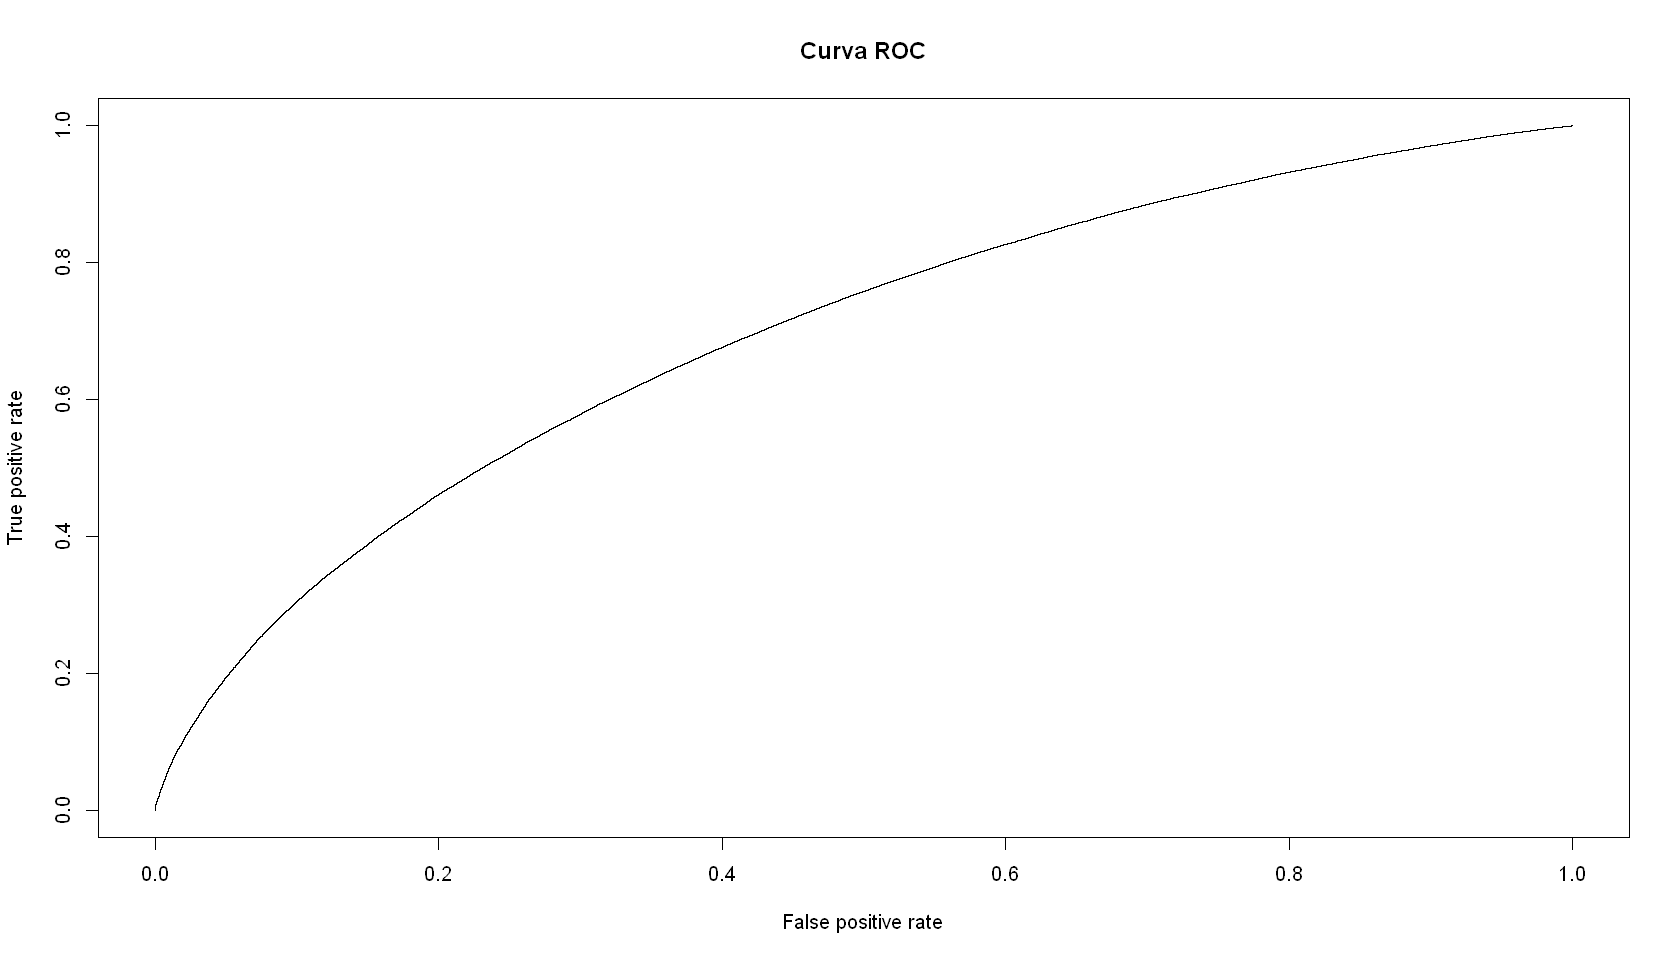

In [56]:
# Plot da curva ROC
perform = performance(outdata, measure = "tpr", x.measure = "fpr")
plot(perform, main = "Curva ROC")

# **Modelo - Árvore de decisão**

In [57]:
# Criação do modelo
tree1 = rpart(formula = (reordered) ~ 
             + add_to_cart_order
             + product_freq
             + aisle_freq
             + department_freq
             + order_number
             + user_avg_days
             + user_last_order,
               data = data_train,
               method = "class")

# Resumo do modelo
printcp(tree1)


Classification tree:
rpart(formula = (reordered) ~ +add_to_cart_order + product_freq + 
    aisle_freq + department_freq + order_number + user_avg_days + 
    user_last_order, data = data_train, method = "class")

Variables actually used in tree construction:
[1] add_to_cart_order department_freq   order_number      product_freq     

Root node error: 444678/1107693 = 0.40145

n= 1107693 

       CP nsplit rel error  xerror      xstd
1 0.05561      0   1.00000 1.00000 0.0011602
2 0.01176      2   0.88878 0.88878 0.0011338
3 0.01097      4   0.86526 0.86791 0.0011277
4 0.01000      5   0.85429 0.85402 0.0011234


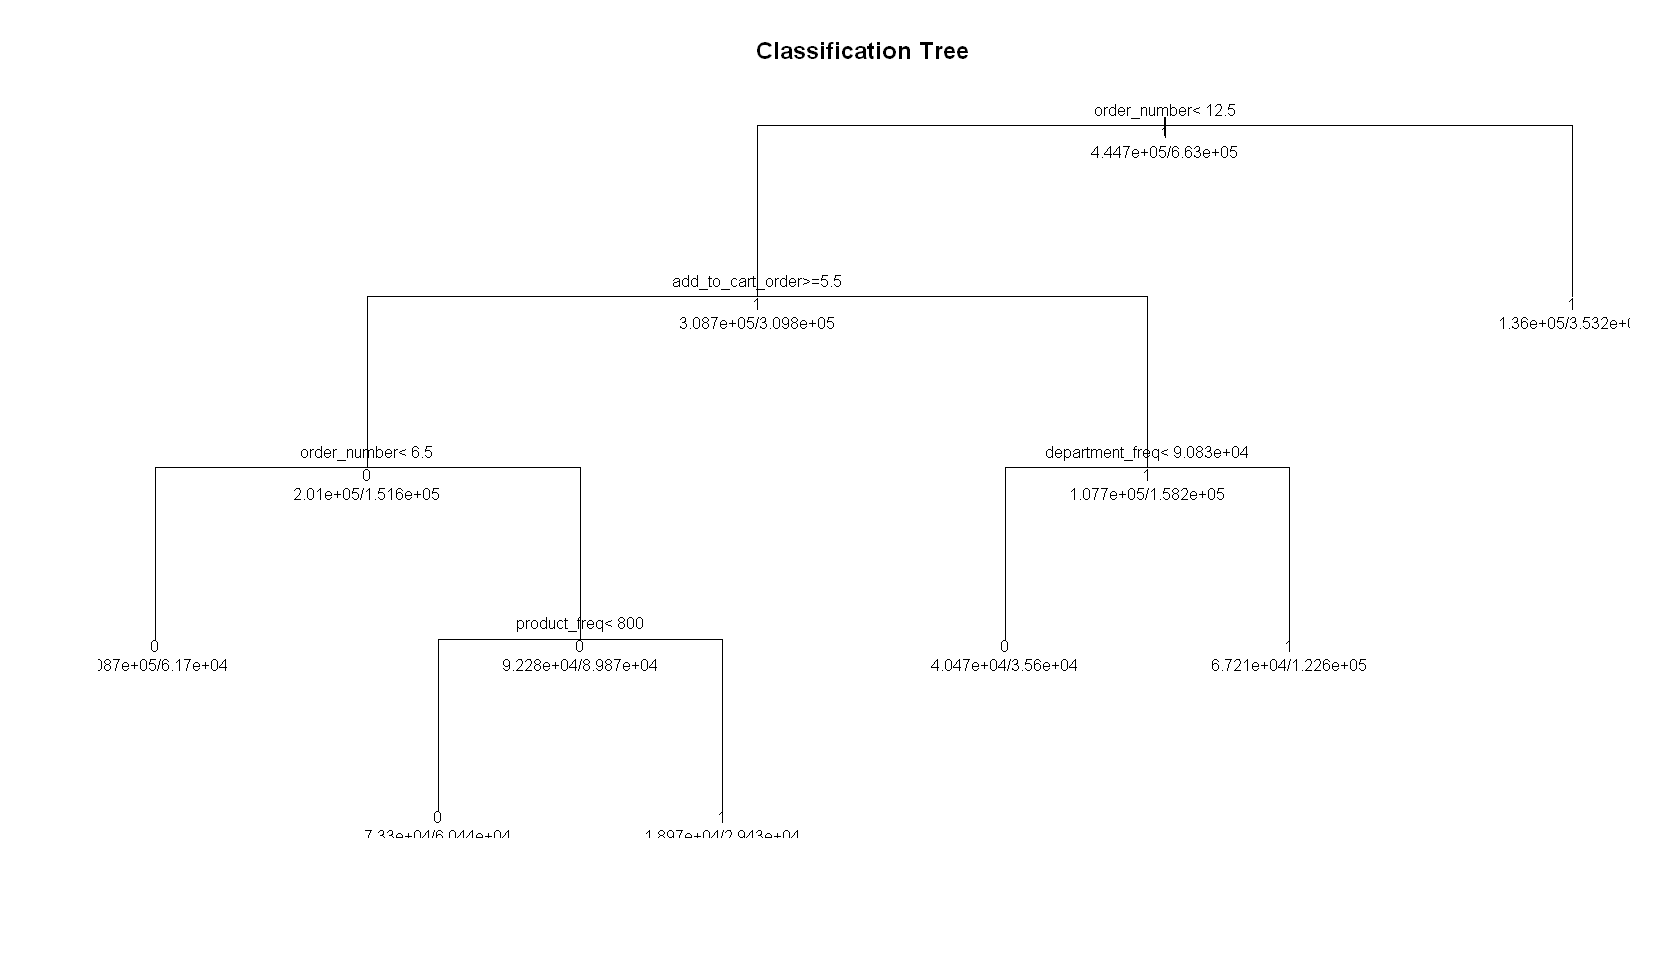

In [58]:
# Plot da árvore de decisão
{plot(tree1, uniform = TRUE, main = "Classification Tree")
text(tree1, use.n = TRUE, all = TRUE, cex = .8)}

[1] 0.01

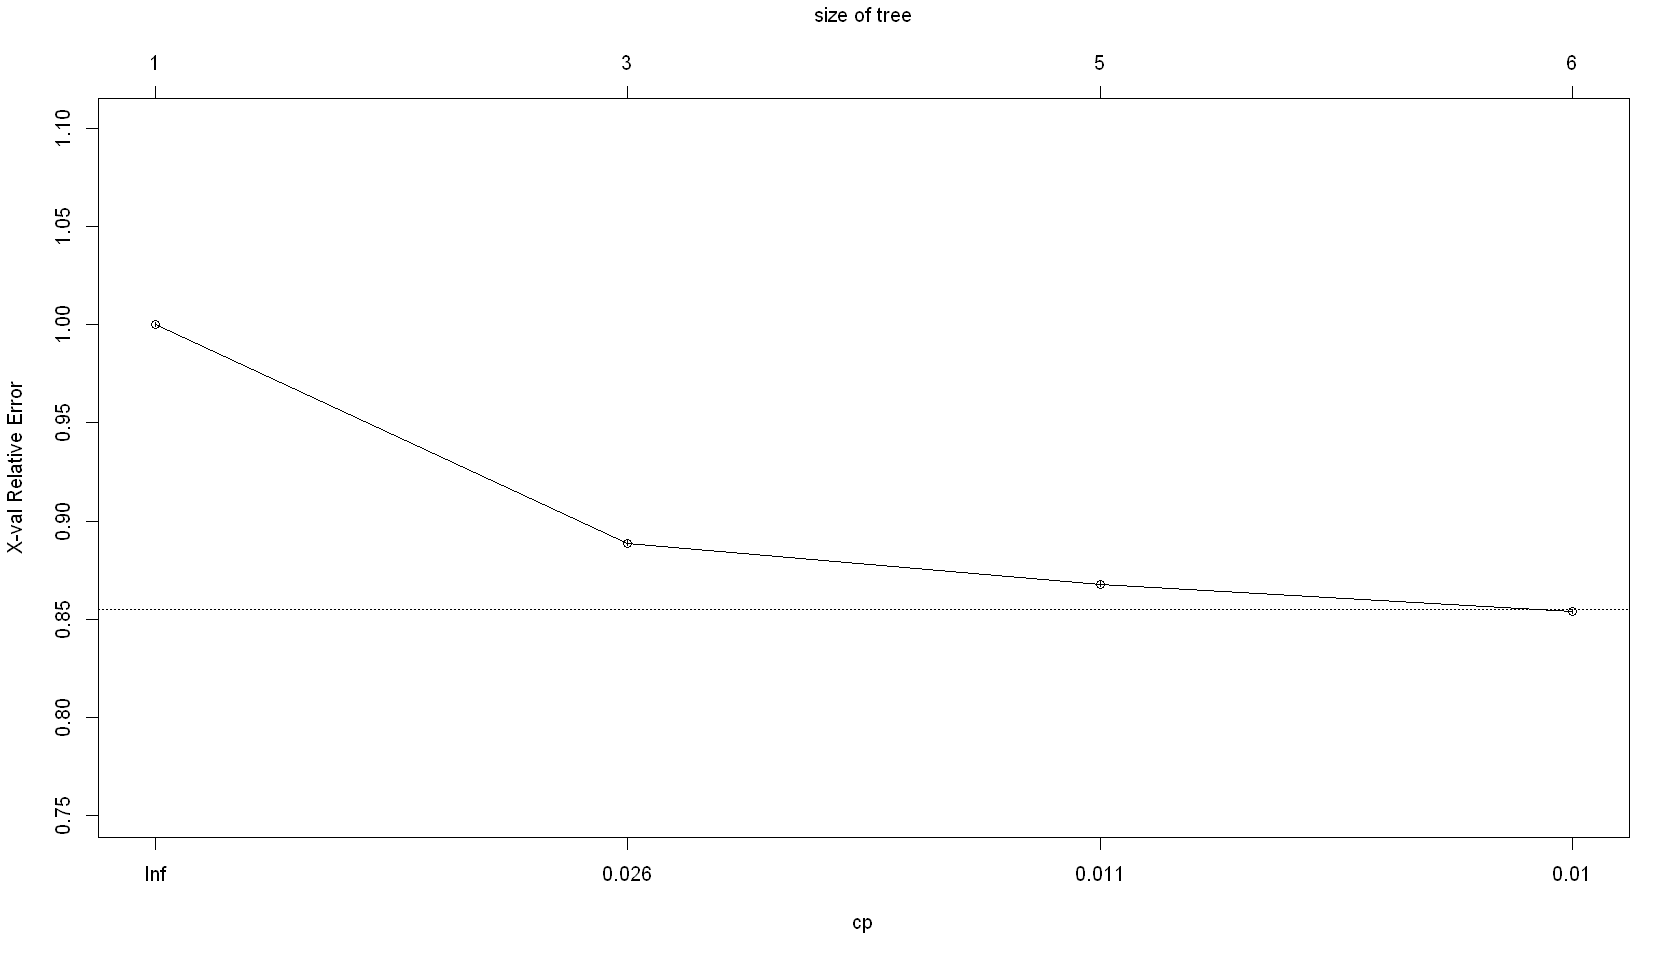

In [59]:
# Plot dos erros
tree1$cptable[which.min(tree1$cptable[,"xerror"]),"CP"]
plotcp(tree1)

In [60]:
# Confusion Matrix -  não é necessário um threshold (considerar 0.5)
ypred = predict(tree1, data_test, type = "prob")
plabel = ifelse(ypred[,2] > 0.5, 1, 0)
outdata_binario = list("prediction" = plabel) 
pred_tree = as.data.frame(outdata_binario)
pred_tree$prediction = factor(pred_tree$prediction, labels = c("no", "yes"))
data_test$reordered = factor(data_test$reordered, labels = c("no", "yes"))
confusionMatrix(data = factor(pred_tree$prediction), reference = data_test$reordered)

Confusion Matrix and Statistics

          Reference
Prediction     no    yes
       no   55872  39634
       yes  55243 126175
                                          
               Accuracy : 0.6574          
                 95% CI : (0.6556, 0.6592)
    No Information Rate : 0.5988          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2701          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5028          
            Specificity : 0.7610          
         Pos Pred Value : 0.5850          
         Neg Pred Value : 0.6955          
             Prevalence : 0.4012          
         Detection Rate : 0.2018          
   Detection Prevalence : 0.3449          
      Balanced Accuracy : 0.6319          
                                          
       'Positive' Class : no              
            

In [61]:
# Cálculo da Área Under the Curve (AUC) - valores binários
pred = prediction(outdata_binario, data_test$reordered)
AUC_tree_bin = performance(pred, measure = "auc")
AUC_tree_bin = AUC_tree_bin@y.values[[1]]
AUC_tree_bin

[1] 0.6318982

In [62]:
# Cálculo da Área Under the Curve (AUC) - valores contínuos
outdata = prediction(ypred[,2], data_test$reordered)
AUC_tree = performance(outdata,"auc")
AUC_tree = AUC_tree@y.values[[1]]
AUC_tree

[1] 0.6544409

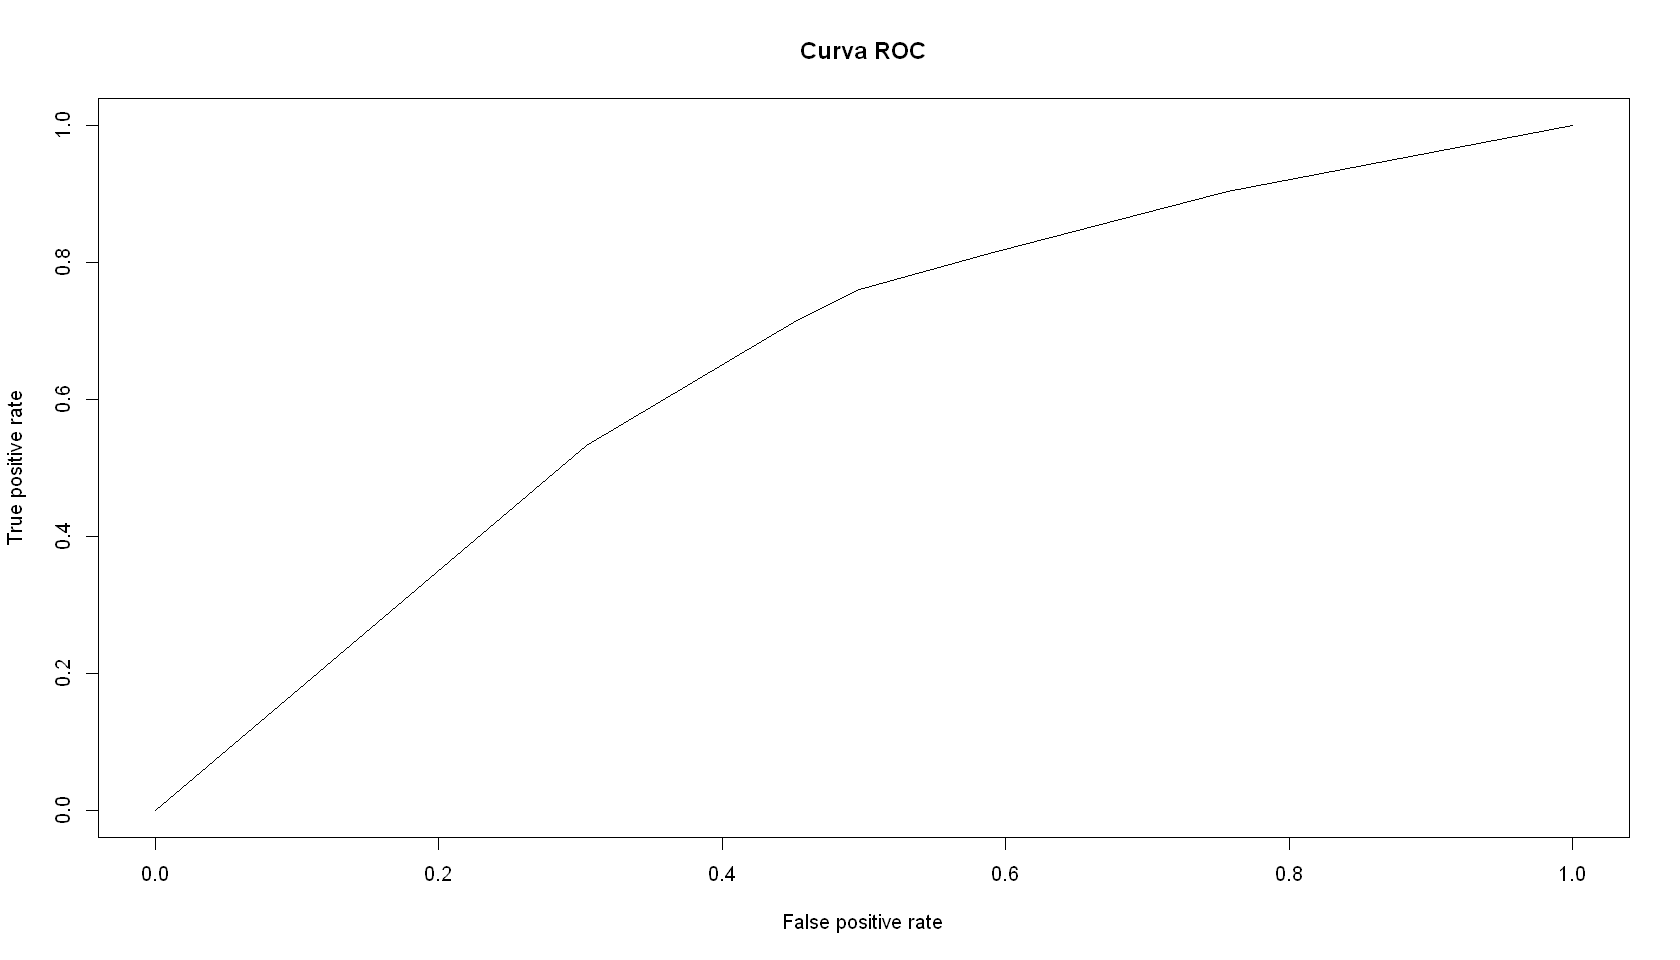

In [63]:
# Plot da curva ROC
perform = performance(outdata, measure = "tpr", x.measure = "fpr")
plot(perform, main = "Curva ROC")

## **Resumo**

Com os resultados de 3 diferentes modelos, conclui-se que o modelo feito com o XGBoost é o mais adequado. Ele obteve os melhores resultados de AUC e acurácia, calculada pela confusionMatrix. 

In [ ]:
##################### XGBoost ######################   

# AUC bin = 0.66717 
# AUC = 0.73564
# Accuracy : 0.6802

#              Reference
# Prediction     no    yes
#        no   66863  44307  =  88.559 predições incorretas
#        yes  44252 121502  = 188.365 predições corretas   

############### Regressão Logística ################  

# AUC bin = 0.61631
# AUC = 0.69349
# Accuracy : 0.6559

#              Reference
# Prediction     no    yes
#       no   46226  30409  =  95.298 predições incorretas
#       yes  64889 135400  = 181.626 predições corretas


################ Árvore de Decisão ################  

# AUC bin = 0.63189
# AUC = 0.65444
# Accuracy : 0.6574   

#              Reference
# Prediction     no    yes
#        no   55872  39634  =  94.877 predições incorretas
#        yes  55243 126175  = 182.047 predições corretas                      